# <center> Projet 5 : Segmentez des clients d'un site e-commerce
    Notebook Modélisation

On va faire une segmentation des clients :

- ACP
- Kmeans
- DBscan ou T-SNE

# 1. Importation des modules et données

In [48]:
# Standards Librairies import
import pandas as pd 
from numpy import arange
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from time import time
from datetime import datetime, timedelta

In [49]:
# Personnal scripts
import functions as fct

In [50]:
#path for cleaned dataset
dataset_cleaned = pd.read_csv("C:\\Users\Marwa\Downloads\projet5\data_cleaned_final.csv")

In [51]:
#Copy
dataset=dataset_cleaned.copy()

In [52]:
dataset.shape

(93358, 18)

In [53]:
dataset.set_index('customer_unique_id', inplace=True)

In [54]:
dataset.isna().sum()

nb_orders                       0
total_spend                     0
mean_review_score               0
mean_delivery_days              0
books_cds_media                 0
fashion_clothing_accessories    0
flowers_gifts                   0
groceries_food_drink            0
health_beauty                   0
home_furniture                  0
other                           0
sport                           0
technology                      0
toys_baby                       0
order_mean_delay                0
freight_ratio                   0
customer_zip_code_prefix        0
dtype: int64

In [55]:
dataset.dtypes

nb_orders                         int64
total_spend                     float64
mean_review_score               float64
mean_delivery_days              float64
books_cds_media                 float64
fashion_clothing_accessories    float64
flowers_gifts                   float64
groceries_food_drink            float64
health_beauty                   float64
home_furniture                  float64
other                           float64
sport                           float64
technology                      float64
toys_baby                       float64
order_mean_delay                float64
freight_ratio                   float64
customer_zip_code_prefix          int64
dtype: object

# 2. K-means

### Preprocessing

In [56]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
dataset = dataset.drop(categories_col, axis=1)
dataset.head(3)

,nb_orders,total_spend,mean_review_score,mean_delivery_days,order_mean_delay,freight_ratio,customer_zip_code_prefix
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,5.0,6.0,111.0,0.08,7787
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,4.0,3.0,114.0,0.30,6053
0000f46a3911fa3c0805444483337064,1,86.22,3.0,26.0,537.0,0.20,88115


In [57]:
#On repère les données qualitatives et quantitatives 
données_numériques= dataset.select_dtypes(include=["float64","int64"]).columns

In [58]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, données_numériques)])

### Méthode du coude

Un pipeline SKLearn est créé pour y inclure le preprocessing et la visualisation de la méthode du coude de notre KMeans.

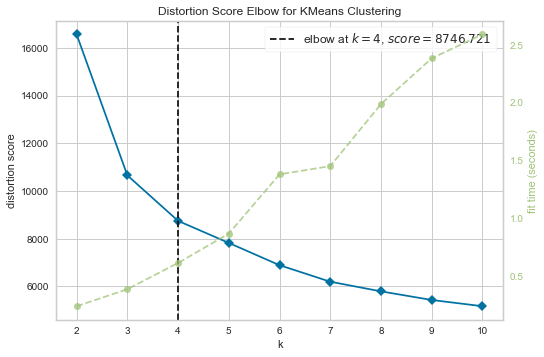

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
X = dataset.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce à la méthode du coude basée sur le score de distortion *(somme moyenne des carrés des distances aux centres)*, une segementation en K = 4 clusters serait la meilleure option.

### Coefficient de silhouette
Pour vérifier si ce clustering fonctionne, nous allons utiliser `SilhouetteVisualizer` pour afficher le **coefficient de silhouette pour un échantillonage de chaque cluster**. Cela permet de visualiser la densité et la séparation des clusters. 

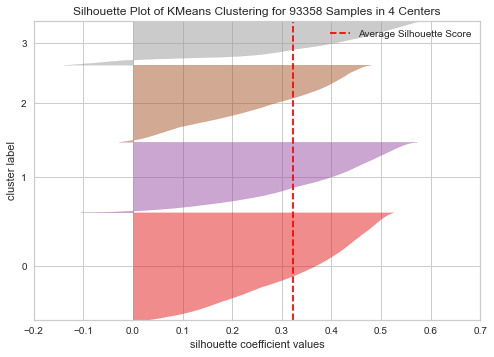

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [60]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,

### Distances intercluster

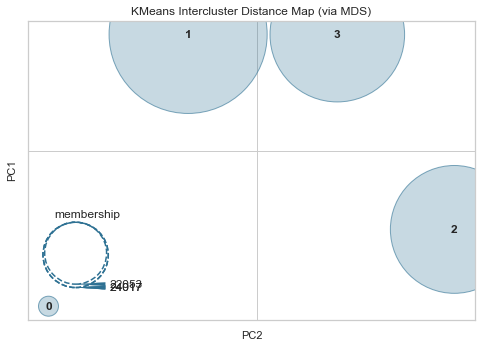

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [61]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent **identifier les composantes de chaque cluster**.

### Analyse des clusters

In [62]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
dataset["kmeans_label"] = kmeans_labels

In [63]:
kmeans_clusters_means = dataset.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,nb_orders,total_spend,mean_review_score,mean_delivery_days,order_mean_delay,freight_ratio,customer_zip_code_prefix
0,0,1.031424,179.012629,4.577278,14.747190,238.445908,0.237629,79584.613250
1,1,1.060709,156.452080,4.650835,9.333423,117.647595,0.194550,17063.779267
2,2,1.027203,188.250260,1.481268,19.984058,228.442858,0.217022,36171.293236
3,3,1.000707,151.520766,4.610567,10.699141,389.613051,0.195028,19437.570116


In [64]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,nb_orders,total_spend,mean_review_score,mean_delivery_days,order_mean_delay,freight_ratio,customer_zip_code_prefix
kmeans_label,,,,,,,
0,0.002245,0.012408,0.894319,0.065776,0.334426,0.247530,0.793938
1,0.004336,0.010756,0.912709,0.039873,0.165004,0.202656,0.162268
2,0.001943,0.013084,0.120317,0.090833,0.320397,0.226064,0.355318
3,0.000050,0.010394,0.902642,0.046407,0.546442,0.203154,0.186251


Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [65]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [66]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

In [19]:
#from IPython.display import Image 
#Image(filename="C:\\Users\Marwa\Downloads\projet5\newplot.png")

### Interprétation des clusters

**Le cluster 1** correspond aux clients qui sont moyennement depenciès et ils sont très satisfaits (avis positifs). Ces clients semblent étre un peu éloignées géographiquement.

**Le cluster 2** correspond aux clients qui passé un nombre élevé de commandes. Les délai et les frais de livraison de ces clients sont faibles car ils sont géographiquement proches. Ils sont aussi des clients très satisfaits.

**Le cluster 3** correspond aux clients qui ne passent pas trop de commandes mais qui depensent trop. Par contre, ils sont très satisfaits (les avis de ces clients sont très bons). Ils sont moyennement proches géographiquement vu que le délai et les frais de livraison sont moyennement faible. 

**Le cluster 4** correspond aux clients qui son satisfaits. Ils ne dépensent pas trop (total_spend est faible). Ils sont très loin géographiquement vu que le délai et les frais de livraison sont élévés. 

# 3. ACP : Analyse des composantes principales

L’ACP est une méthode exploratoire (i.e., descriptive) qui permet de décrire un jeu de données multivarié, de le résumer, d’en réduire la dimensionnalité. C'est une méthode d'analyse de données multivariée. Elle permet d'explorer des jeux de données multidimensionnels constitués de variables quantitatives.

On va l'utiliser dans cette partie pour faire une réduction dimensionnelle.

In [67]:
#Copy
X_bis=dataset.copy()

In [68]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis)
X_projected = pca.transform(X_bis)

### Eboulis des valeurs propres

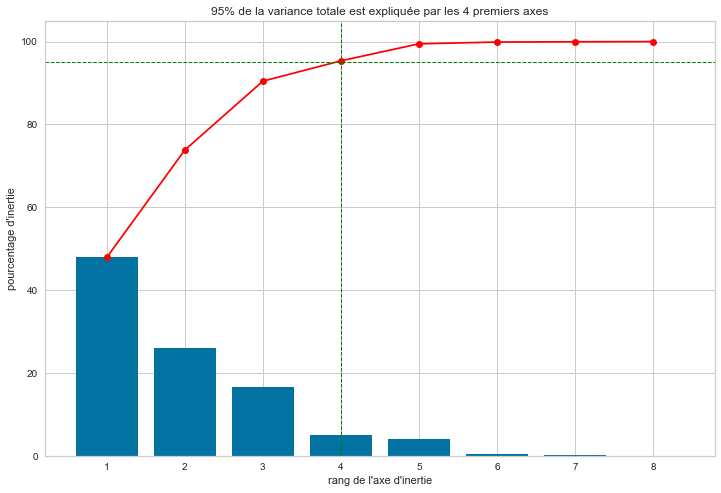

In [69]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

Il faut donc conserver 5 axes principaux pour expliquer la variance à 95%.

### Cercle des corrélations

In [70]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

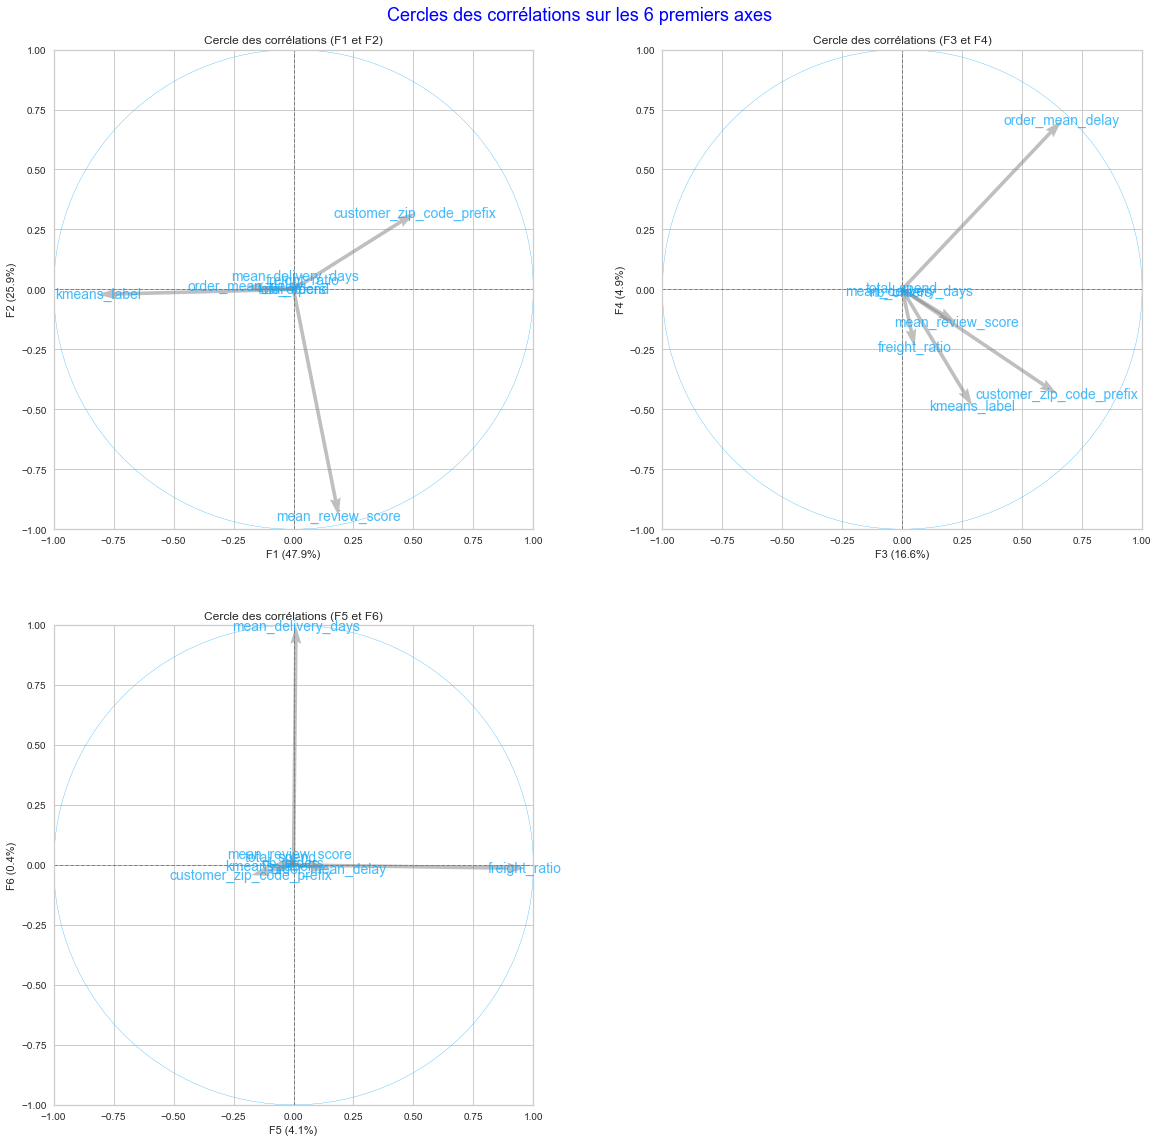

In [71]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X_bis.columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple, la variable synthétique $\large F_2$ représentera les périodes d'achats. La variable synthétique $\large F_4$ quant à elle représente l'aspect géographique.

Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 5 composantes pour **vérifier si la réduction dimensionnelle réduit la qualité de la segmentation** :

# 4. K-Means après ACP

Nous allons intégrer à notre modèle Kmeans une PCA sur les composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation :

In [72]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('kmeans', KMeans(n_clusters=4))])

In [73]:
# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

In [74]:
# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

In [75]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

,nb_orders,total_spend,mean_review_score,mean_delivery_days,order_mean_delay,freight_ratio,customer_zip_code_prefix
kmeans_label_pca,,,,,,,
0,0.000050,0.010394,0.902642,0.046407,0.546442,0.203154,0.186251
1,0.002245,0.012408,0.894319,0.065776,0.334426,0.247530,0.793938
2,0.004336,0.010756,0.912709,0.039873,0.165004,0.202656,0.162268
3,0.001943,0.013084,0.120317,0.090833,0.320397,0.226064,0.355318


In [76]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

### Interprétation des clusters

**Le cluster 1** correspond aux clients qui son satisfaits. Ils ne dépensent pas trop (total_spend est faible). Ils sont très loin géographiquement vu que le délai et les frais de livraison sont élévés. 

**Le cluster 2** correspond aux clients qui sont moyennement depenciès et ils sont très satisfaits (avis positifs). Ces clients semblent étre un peu éloignées géographiquement.

**Le cluster 3** correspond aux clients qui passé un nombre élevé de commandes. Les délai et les frais de livraison de ces clients sont faibles car ils sont géographiquement proches. Ils sont aussi des clients très satisfaits.

**Le cluster 4** correspond aux clients qui ne passent pas trop de commandes mais qui depensent trop. Par contre, ils sont très satisfaits (les avis de ces clients sont très bons). Ils sont moyennement proches géographiquement vu que le délai et les frais de livraison sont moyennement faible.

On remarque donc ici que **la réduction de dimenssion offre les mêmes axes de segmentation**. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client.

# 5. T-SNE

utilisons l'algorithme T-SNE pour avoir une idée sur le nombre de groupes homogènes (avant ACP)

In [77]:
#Copy
dataset_sne=dataset.copy()

In [78]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(dataset_sne)

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



C:\Users\Marwa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Représentation du dataset via T-SNE'}>

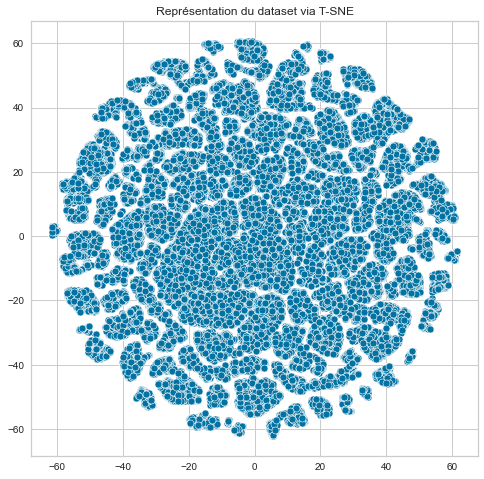

In [79]:
plt.figure(figsize=(8,8))
plt.title('Représentation du dataset via T-SNE')
sns.scatterplot(T[:,0], T[:,1])

# 6. DBSCAN

In [80]:
#Copy
dataset_D=dataset.copy()

In [81]:
dbs = DBSCAN(eps = 1, 
             min_samples=5,
               n_jobs=-1).fit(dataset_D.copy())

C:\Users\Marwa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Représentation de la séparation des données du DBSCAN via T-SNE'}>

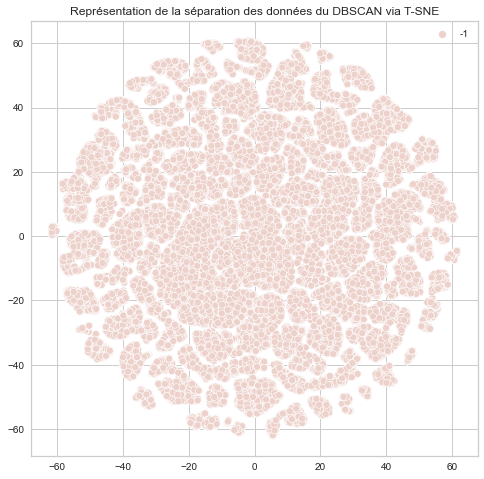

In [82]:
plt.figure(figsize=(8,8))
plt.title('Représentation de la séparation des données du DBSCAN via T-SNE')
sns.scatterplot(T[:,0], T[:,1], dbs.labels_)

# Contrat de maintenance

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée.

In [83]:
orders = pd.read_csv("C:\\Users\Marwa\Downloads\projet5\olist_orders_dataset.csv")

In [84]:
import functions_1 as fct

In [85]:
# Initial period of 12 months
data_init = fct.make_dataset(initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 9.45s


Nous allons ensuite déterminer la période totale à couvrir :

In [86]:
orders = pd.read_csv("C:\\Users\Marwa\Downloads\projet5\olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons **itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI**, en prenant garde à bien comparer les mêmes clients *(ceux des 12 mois initiaux)*. 

In [87]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [88]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = fct.make_dataset(initial=False, 
                                   period=p)
    #data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    #data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(data_period), kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 12.33s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 16.51s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
_____________________________

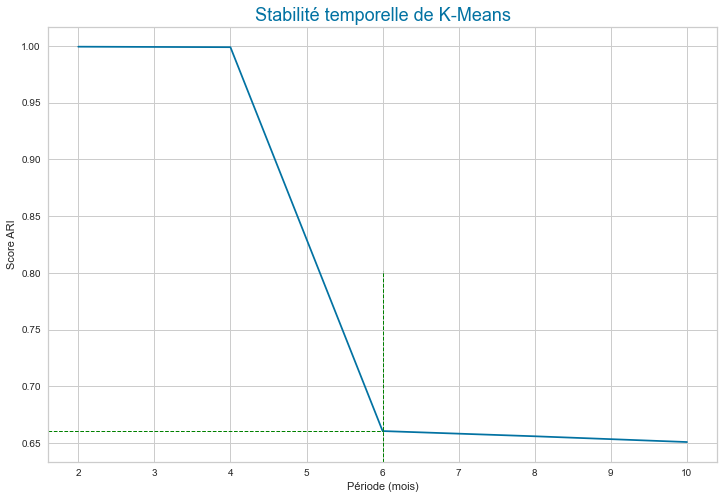

In [89]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période de 2 mois, on remarque qu'il n'y a pas une forte inflexion méme après 10 mois.

On aura besoin donc **une maintenance du programme de segmentation** tout le 5 mois.

# Conclusion

Le Kmeans semble mieux fonctionner que les autres méthodes de clustering.

On aura besoin donc **une maintenance du programme de segmentation** tout le 5 mois.